In [3]:
import tensorflow.compat.v1 as tf1
# import tensorflow as tf2
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
config = tf1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
session = tf1.Session(config=config)

2024-11-20 00:02:33.368469: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20169 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:86:00.0, compute capability: 8.0


In [7]:
import pandas as pd

df = pd.read_csv('FracAtlas/dataset.csv')

# fracture_count가 5인 데이터를 필터링
filtered_data = df[df['fracture_count'] == 5]

# 결과 데이터프레임 출력
filtered_data

,image_id,hand,leg,hip,shoulder,mixed,hardware,multiscan,fractured,fracture_count,frontal,lateral,oblique
2539,IMG0002572.jpg,0,1,0,0,0,0,1,1,5,1,1,0


29 76 18 52
67 250 11 31
48 209 8 53
252 233 24 30
250 77 13 15


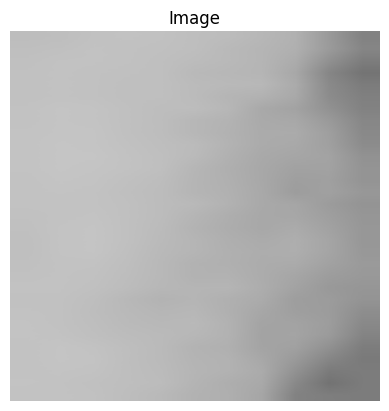

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def load_yolo_annotation(file_path):
    with open(file_path, 'r') as f:
        annotations = f.readlines()
    
    # 각 라인에서 YOLO 포맷 정보를 추출
    annotations = [line.strip().split() for line in annotations]
    
    return annotations

def convert_yolo_to_pixel(yolo_annotation, img_width, img_height):
    """YOLO 어노테이션을 픽셀 좌표로 변환."""
    _, center_x, center_y, width, height = map(float, yolo_annotation)
    box_x = int((center_x - width / 2) * img_width)
    box_y = int((center_y - height / 2) * img_height)
    box_w = int(width * img_width)
    box_h = int(height * img_height)
    return box_x, box_y, box_w, box_h

def draw_bounding_box(image, box_x, box_y, box_w, box_h):
    """이미지에 YOLO 박스를 그림."""
    image_with_box = image.copy()
    cv2.rectangle(image_with_box, (box_x, box_y), (box_x + box_w, box_y + box_h), (255, 0, 0), 2)
    return image_with_box

def crop_bounding_box(image, box_x, box_y, box_w, box_h):
    """이미지에서 YOLO 박스를 crop."""
    return image[box_y:box_y + box_h, box_x:box_x + box_w]

def show_image(image, title="Image"):
    """이미지를 Matplotlib로 표시."""
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

def process_image(image_path, annotation_path):
    # 이미지 불러오기
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    yolo_annotations = load_yolo_annotation(yolo_file_path)
    
    # YOLO 좌표를 픽셀 단위로 변환
    img_height, img_width, _ = image.shape
    
    images = []
    
    for annotation in yolo_annotations:
        
        box_x, box_y, box_w, box_h = convert_yolo_to_pixel(annotation, img_width, img_height)
        print(box_x, box_y, box_w, box_h)
        # 1. 박스 그리기
        image_with_box = draw_bounding_box(image, box_x, box_y, box_w, box_h)

        # 2. 박스 영역 자르기
        cropped_image = crop_bounding_box(image, box_x, box_y, box_w, box_h)
        resize_image = cv2.resize(cropped_image, (512, 512))
        
        images.append(resize_image)
    return np.array(images)


# YOLO 어노테이션 경로
yolo_file_path = 'FracAtlas/Annotations/YOLO/IMG0002572.txt'

# 이미지 경로
image_path = 'FracAtlas/images/Fractured/IMG0002572.jpg'

image = process_image(image_path, yolo_file_path)
show_image(image[1])

In [20]:
def fill_polygons_with_alpha(image, polygons, alpha=0.2):  # 이미지, 폴리곤, 투명도(alpha) 입력
    # 이미지를 RGBA로 변환 (알파 채널 추가)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGRA)
    
    # 알파 값으로 설정된 색상 (예: 회색 255로 설정)
    overlay_color = (255, 255, 255, int(255 * alpha))
    
    # 폴리곤 채우기
    for x_coords, y_coords in polygons:
        pts = np.array([list(zip(x_coords, y_coords))], dtype=np.int32)
        # 원본 이미지와 투명도를 적용한 오버레이 이미지 생성
        overlay = image.copy()
        cv2.fillPoly(overlay, pts, color=overlay_color)
        # 투명도를 반영한 합성
        image = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)

    return image


def canny_edge_detection(image, low_threshold=50, high_threshold=150): 

    # Canny Edge Detection 적용
    edges = cv2.Canny(image, low_threshold, high_threshold)

    return edges

def sharpen_image(image):
    # 샤프닝 커널 정의
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]], dtype=np.float32)

    # 필터 적용하여 샤프닝 수행
    sharpened_image = cv2.filter2D(image, -1, kernel)

    return sharpened_image

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

def load_yolo_annotation(file_path):
    """
    YOLO 어노테이션 파일을 읽어 첫 번째 라인의 어노테이션을 반환하는 함수.

    Parameters:
        file_path (str): YOLO 어노테이션 파일 경로.
    
    Returns:
        list: YOLO 어노테이션 값 (class_id, center_x, center_y, width, height).
    """
    with open(file_path, 'r') as f:
        annotations = f.readlines()
    annotations = [line.strip().split() for line in annotations]
    return annotations[0]

def convert_yolo_to_pixel(yolo_annotation, img_width, img_height):
    """
    YOLO 어노테이션 좌표를 픽셀 좌표로 변환하는 함수.

    Parameters:
        yolo_annotation (list): YOLO 어노테이션 값 (class_id, center_x, center_y, width, height).
        img_width (int): 이미지의 가로 길이 (픽셀).
        img_height (int): 이미지의 세로 길이 (픽셀).
    
    Returns:
        tuple: 변환된 박스 좌표 (box_x, box_y, box_w, box_h).
    """
    _, center_x, center_y, width, height = map(float, yolo_annotation)
    box_x = int((center_x - width / 2) * img_width)
    box_y = int((center_y - height / 2) * img_height)
    box_w = int(width * img_width)
    box_h = int(height * img_height)
    return box_x, box_y, box_w, box_h

def draw_bounding_box(image, box_x, box_y, box_w, box_h):
    """
    이미지에 YOLO 박스를 그리는 함수.

    Parameters:
        image (numpy.ndarray): 원본 이미지.
        box_x (int): 박스의 좌측 상단 x 좌표.
        box_y (int): 박스의 좌측 상단 y 좌표.
        box_w (int): 박스의 가로 길이.
        box_h (int): 박스의 세로 길이.
    
    Returns:
        numpy.ndarray: 박스가 그려진 이미지.
    """
    image_with_box = image.copy()
    cv2.rectangle(image_with_box, (box_x, box_y), (box_x + box_w, box_y + box_h), (255, 0, 0), 2)
    return image_with_box

def crop_bounding_box(image, box_x, box_y, box_w, box_h):
    """
    이미지에서 지정된 YOLO 박스 영역을 잘라내는 함수.

    Parameters:
        image (numpy.ndarray): 원본 이미지.
        box_x (int): 박스의 좌측 상단 x 좌표.
        box_y (int): 박스의 좌측 상단 y 좌표.
        box_w (int): 박스의 가로 길이.
        box_h (int): 박스의 세로 길이.
    
    Returns:
        numpy.ndarray: 잘라낸 이미지 영역.
    """
    return image[box_y:box_y + box_h, box_x:box_x + box_w]

def show_image(image, title="Image", show_flag=True):
    """
    이미지를 Matplotlib를 이용하여 표시하는 함수.
    
    Parameters:
        image (numpy.ndarray): 표시할 이미지.
        title (str): 이미지의 제목 (기본값: "Image").
        show_flag (bool): 이미지를 출력할지 여부 (기본값: True).
    """
    if show_flag:
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')
        plt.show()

def process_image(image_path, annotation_path, draw_box=True, show_image_flag=True):
    """
    이미지와 YOLO 어노테이션 파일을 처리하여 박스를 자른 이미지를 반환하는 함수.
    박스를 그릴지 여부는 draw_box 하이퍼파라미터로 결정.

    Parameters:
        image_path (str): 이미지 파일 경로.
        annotation_path (str): YOLO 어노테이션 파일 경로.
        draw_box (bool): 박스를 그릴지 여부 (기본값: True).
        show_image_flag (bool): 이미지를 출력할지 여부 (기본값: True).
    
    Returns:
        numpy.ndarray: 잘라낸 이미지 영역.
    """
    # 이미지 로드 및 RGB 변환
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # YOLO 어노테이션 로드
    yolo_annotation = load_yolo_annotation(annotation_path)
    
    # 이미지 크기 가져오기
    img_height, img_width, _ = image.shape
    
    # YOLO 좌표를 픽셀 단위로 변환
    box_x, box_y, box_w, box_h = convert_yolo_to_pixel(yolo_annotation, img_width, img_height)

    # 1. 박스 그리기 (선택적)
    if draw_box:
        image_with_box = draw_bounding_box(image, box_x, box_y, box_w, box_h)
        show_image(image_with_box, title="Image with Box", show_flag=show_image_flag)

    # 2. 박스 영역 잘라내기
    cropped_image = crop_bounding_box(image, box_x, box_y, box_w, box_h)
    
    return cropped_image

def get_filenames_without_extension(directory_path):
    """
    디렉토리에서 확장자를 제외한 파일 이름 목록을 반환하는 함수.

    Parameters:
        directory_path (str): 디렉토리 경로.
    
    Returns:
        list: 디렉토리 내 파일 이름 목록 (확장자 제외).
    """
    return [os.path.splitext(file_name)[0] for file_name in os.listdir(directory_path)]

def process_images_from_directories(image_dir, yolo_dir, draw_box=True, show_image_flag=True):
    """
    이미지 디렉토리와 YOLO 어노테이션 디렉토리를 처리하여 이미지를 잘라내고 결과를 출력하는 함수.
    박스를 그릴지 여부는 draw_box 하이퍼파라미터로 결정.

    Parameters:
        image_dir (str): 이미지 파일이 포함된 디렉토리 경로.
        yolo_dir (str): YOLO 어노테이션 파일이 포함된 디렉토리 경로.
        draw_box (bool): 박스를 그릴지 여부 (기본값: True).
        show_image_flag (bool): 이미지를 출력할지 여부 (기본값: True).
    """
    # 디렉토리에서 파일 이름 가져오기
    file_names = get_filenames_without_extension(image_dir)
    
    for file_name in file_names:
        # 이미지와 YOLO 어노테이션 경로 생성
        image_path = os.path.join(image_dir, f"{file_name}.jpg")
        annotation_path = os.path.join(yolo_dir, f"{file_name}.txt")
        
        # 파일이 실제로 존재하는지 확인
        if os.path.exists(image_path) and os.path.exists(annotation_path):
            # 이미지 처리
            cropped_image = process_image(image_path, annotation_path, draw_box=draw_box, show_image_flag=show_image_flag)
            
            # 결과 출력
            show_image(cropped_image, title=f"Cropped: {file_name}", show_flag=show_image_flag)
        else:
            print(f"파일 누락: {file_name}.jpg 또는 {file_name}.txt")

# 디렉토리 경로 설정
image_directory = 'FracAtlas/images/Fractured'
yolo_directory = 'FracAtlas/Annotations/YOLO'

# 이미지와 YOLO 어노테이션 처리 실행 (박스를 그리지 않으려면 draw_box=False로 설정)
process_images_from_directories(image_directory, yolo_directory, draw_box=True, show_image_flag=False)

In [2]:
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import backend as K
from tensorflow.keras import layers

# 이미지 파일을 읽고 그레이스케일로 변환하는 함수
def open_image(image_dir, image_file):
    """
    주어진 이미지 파일을 열고, 그레이스케일로 변환하여 반환합니다.

    매개변수:
    - image_dir (str): 이미지 파일이 위치한 디렉토리 경로.
    - image_file (str): 열고자 하는 이미지 파일명.

    반환값:
    - image (numpy.ndarray): 그레이스케일로 변환된 이미지 배열.
    """
    image_path = os.path.join(image_dir, image_file)  # 이미지 파일 경로 생성
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2GRAY)  # 이미지를 그레이스케일로 변환하여 반환

# 이미지를 가로로 나열하여 시각화하는 함수
def visualize_width_image(images):
    """
    주어진 이미지를 가로로 나열하여 시각화합니다.

    매개변수:
    - images (list of numpy.ndarray): 시각화할 이미지 목록.

    반환값:
    - None: 이미지들을 시각화하여 출력합니다.
    """
    plt.figure(figsize=(5 * len(images), 5))  # 이미지의 개수에 맞게 시각화 크기 설정
    for idx, image in enumerate(images):
        plt.subplot(1, len(images), idx + 1)  # 가로로 이미지를 나열
        plt.imshow(image, cmap='gray')  # 이미지를 회색조로 표시
        plt.axis('off')  # 축 표시 끄기
    plt.show()

# 이미지를 세로로 나열하여 시각화하는 함수
def visualize_hight_image(images):
    """
    주어진 이미지를 세로로 나열하여 시각화합니다.

    매개변수:
    - images (list of numpy.ndarray): 시각화할 이미지 목록.

    반환값:
    - None: 이미지들을 시각화하여 출력합니다.
    """
    plt.figure(figsize=(5, 5 * len(images)))  # 이미지 개수에 맞게 세로 크기 설정
    for idx, image in enumerate(images):
        plt.subplot(len(images), 1, idx + 1)  # 세로로 이미지를 나열
        plt.imshow(image, cmap='gray')  # 이미지를 회색조로 표시
        plt.axis('off')  # 축 표시 끄기
    plt.show()

# JSON 파일을 열고 데이터를 반환하는 함수
def open_json(json_path):
    """
    JSON 파일을 열고, 내용을 반환합니다.

    매개변수:
    - json_path (str): JSON 파일 경로.

    반환값:
    - json_data (dict): JSON 파일에서 읽은 데이터.
    """
    with open(json_path, "r") as f:
        json_data = json.load(f)  # JSON 파일을 열고 내용을 읽어서 반환
    return json_data

# JSON 데이터에서 이미지에 해당하는 폴리곤 좌표를 추출하는 함수
def get_polygon_from_json(json_data, image_filename):
    """
    주어진 JSON 데이터에서 이미지 파일에 해당하는 폴리곤 데이터를 추출하여 반환합니다.

    매개변수:
    - json_data (dict): JSON 데이터.
    - image_filename (str): 폴리곤 정보를 추출할 이미지 파일명.

    반환값:
    - polygons (list of tuple): (x_coords, y_coords)로 이루어진 폴리곤 목록.
    """
    regions = json_data[image_filename]["regions"]  # 이미지에 해당하는 영역 추출
    polygons = []
    for region_id, region_info in regions.items():
        shape_attributes = region_info["shape_attributes"]
        if shape_attributes["name"] == "polygon":  # 폴리곤 형태인 경우
            x_coords = shape_attributes["all_points_x"]
            y_coords = shape_attributes["all_points_y"]
            polygons.append((x_coords, y_coords))  # 폴리곤 좌표를 리스트에 추가
    return polygons

# 주어진 이미지 크기와 동일한 검은색 마스크 이미지를 생성하는 함수
def creat_mask(image):
    """
    주어진 이미지와 동일한 크기의 검은색 마스크 이미지를 생성합니다.

    매개변수:
    - image (numpy.ndarray): 마스크를 생성할 기준 이미지.

    반환값:
    - mask (numpy.ndarray): 검은색으로 채워진 마스크 이미지.
    """
    return np.zeros(image.shape)  # 이미지와 동일한 크기의 0으로 채운 배열을 반환

# 폴리곤을 마스크 이미지에 채우는 함수
def fill_polygons(image, polygons):
    """
    주어진 폴리곤 좌표에 따라 이미지를 채웁니다.

    매개변수:
    - image (numpy.ndarray): 채워질 이미지.
    - polygons (list of tuple): 폴리곤의 x, y 좌표 리스트.

    반환값:
    - image (numpy.ndarray): 폴리곤이 채워진 이미지.
    """
    image = image.copy()  # 원본 이미지를 수정하지 않기 위해 복사본을 사용
    for x_coords, y_coords in polygons:
        pts = np.array([list(zip(x_coords, y_coords))], dtype=np.int32)  # 폴리곤의 x, y 좌표를 합침
        cv2.fillPoly(image, pts, color=255)  # 폴리곤 내부를 흰색으로 채우기
    return image

# 이미지와 JSON 데이터를 기반으로 마스크 이미지를 생성하는 함수
def crate_mask_image(image_dir, json_path, image_file):
    """
    주어진 이미지와 JSON 데이터에서 폴리곤 마스크 이미지를 생성합니다.

    매개변수:
    - image_dir (str): 이미지가 위치한 디렉토리 경로.
    - json_path (str): 폴리곤 정보가 담긴 JSON 파일 경로.
    - image_file (str): 마스크를 생성할 이미지 파일명.

    반환값:
    - mask_image (numpy.ndarray): 폴리곤이 채워진 마스크 이미지.
    """
    json_data = open_json(json_path)  # JSON 파일을 열고 데이터 가져오기
    image = open_image(image_dir, image_file)  # 이미지 읽어오기
    mask_image = creat_mask(image)  # 빈 마스크 이미지 생성
    return fill_polygons(mask_image, get_polygon_from_json(json_data, image_file))  # 폴리곤을 마스크에 채우기

# 이미지를 지정된 크기로 리사이즈하는 함수
def image_resize(image, shape):
    """
    주어진 이미지를 지정된 크기로 리사이즈합니다.

    매개변수:
    - image (numpy.ndarray): 리사이즈할 이미지.
    - shape (tuple): 리사이즈할 크기 (너비, 높이).

    반환값:
    - resized_image (numpy.ndarray): 리사이즈된 이미지.
    """
    return cv2.resize(image, shape)  # OpenCV의 resize 함수로 이미지 크기 변경

# 이미지를 1개의 차원(채널)을 추가하여 반환하는 함수
def expand_dims(image):
    """
    이미지에 새로운 차원을 추가합니다 (채널 차원 추가).

    매개변수:
    - image (numpy.ndarray): 차원을 추가할 이미지.

    반환값:
    - image_with_new_dim (numpy.ndarray): 차원이 추가된 이미지.
    """
    return np.expand_dims(image, axis=-1)  # 채널 차원을 추가하여 3D 이미지로 변환

# 학습 데이터와 검증 데이터를 준비하고, 레이블을 이진화하는 함수
def prepare_and_count_labels(y_train, y_val):
    """
    y_train과 y_val의 레이블을 0과 1로 이진화하고, 각 레이블의 빈도를 출력합니다.

    매개변수:
    - y_train (numpy.ndarray): 학습용 레이블.
    - y_val (numpy.ndarray): 검증용 레이블.

    반환값:
    - y_train (numpy.ndarray): 이진화된 학습용 레이블.
    - y_val (numpy.ndarray): 이진화된 검증용 레이블.
    """
    y_train = np.where(y_train > 0, 1, 0)  # 0보다 큰 값은 1로, 나머지는 0으로 이진화
    y_val = np.where(y_val > 0, 1, 0)  # 동일하게 검증 데이터도 이진화
    unique, counts = np.unique(y_train, return_counts=True)  # 학습 데이터에서 레이블의 빈도 출력
    print("학습 데이터셋 레이블 빈도:", dict(zip(unique, counts)))
    unique, counts = np.unique(y_val, return_counts=True)  # 검증 데이터에서 레이블의 빈도 출력
    print("검증 데이터셋 레이블 빈도:", dict(zip(unique, counts)))
    return y_train, y_val

# 샤프닝 필터를 적용하여 이미지를 선명하게 하는 함수
def sharpen_image(image):
    """
    샤프닝 필터를 적용하여 이미지를 선명하게 만듭니다.

    매개변수:
    - image (numpy.ndarray): 샤프닝할 이미지.

    반환값:
    - sharpened_image (numpy.ndarray): 샤프닝된 이미지.
    """
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], dtype=np.float32)  # 샤프닝 필터 커널
    return cv2.filter2D(image, -1, kernel)  # 필터를 적용하여 이미지 선명하게 만들기

# Canny 엣지 검출을 적용하는 함수
def canny_edge_detection(image):
    """
    Canny 엣지 검출기를 적용하여 이미지의 엣지를 강조합니다.

    매개변수:
    - image (numpy.ndarray): 엣지 검출할 이미지.

    반환값:
    - edge_image (numpy.ndarray): 엣지 검출된 이미지.
    """
    return cv2.Canny(image, 100, 200)  # Canny 엣지 검출 (최소값, 최대값)

# 이미지 정규화 함수
def normalize_image(image):
    """
    이미지를 0과 1 사이로 정규화합니다.

    매개변수:
    - image (numpy.ndarray): 정규화할 이미지.

    반환값:
    - normalized_image (numpy.ndarray): 정규화된 이미지.
    """
    return image / 255.0  # 이미지 값을 0~1 범위로 정규화

def regularize_mask(mask):
    """
    생성된 마스크 이미지를 정규화하여 잡음을 제거하고 품질을 개선합니다.
    
    매개변수:
    - mask (numpy.ndarray): 생성된 마스크 이미지.
    
    반환값:
    - regularized_mask (numpy.ndarray): 정규화된 마스크 이미지.
    """
    # Gaussian Blur로 잡음 제거
    blurred = cv2.GaussianBlur(mask, (5, 5), 0)
    
    # Binary Threshold 적용
    _, binary = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)
    
    # Morphological Transformations (열림 연산)으로 작은 잡음 제거
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    return cleaned

def add_background_channel(mask):
    """
    마스크에서 배경 채널을 추가합니다.
    
    매개변수:
    - mask (numpy.ndarray): 단일 채널 마스크 (0: 배경, 1: 객체).
    
    반환값:
    - multi_channel_mask (numpy.ndarray): 2채널 마스크 (채널 0: 배경, 채널 1: 객체).
    """
    background = 1 - mask  # 배경 채널은 객체 채널의 반전값
    multi_channel_mask = np.stack([background, mask], axis=-1)  # 채널 축으로 쌓음
    return multi_channel_mask

# 데이터셋을 준비하고 전처리하는 함수
def prepare_dataset(image_dir, json_path, image_size=(512, 512), test_size=0.2, random_state=42):
    """
    이미지 디렉토리와 JSON 파일을 사용하여 데이터를 준비하고 학습 및 검증 데이터셋을 반환합니다.
    이미지 전처리로 샤프닝과 Canny 엣지 검출을 수행합니다.

    매개변수:
    - image_dir (str): 이미지가 저장된 디렉토리 경로.
    - json_path (str): 폴리곤 정보가 담긴 JSON 파일 경로.
    - image_size (tuple): 이미지 크기 (기본값: (512, 512)).
    - test_size (float): 테스트 데이터 비율 (기본값: 0.2).
    - random_state (int): 랜덤 시드 값 (기본값: 42).

    반환값:
    - x_train (numpy.ndarray): 전처리된 학습 이미지.
    - x_val (numpy.ndarray): 전처리된 검증 이미지.
    - y_train (numpy.ndarray): 학습 이미지 마스크.
    - y_val (numpy.ndarray): 검증 이미지 마스크.
    """
    image = []
    image_mask = []

    for image_file in os.listdir(image_dir):  # 이미지 디렉토리에서 파일 목록 가져오기
        if image_file.endswith('.jpg'):  # .jpg 확장자 파일만 처리
            img = open_image(image_dir, image_file)  # 이미지 읽기
            
            # 샤프닝과 Canny 엣지 검출 전처리 적용
            sharpened_img = sharpen_image(img)
            edge_detected_img = canny_edge_detection(sharpened_img)
            
            # 이미지 크기 변경 및 정규화
            edge_detected_img = np.expand_dims(image_resize(edge_detected_img, image_size), axis=-1)  # 크기 조정 후 차원 추가
            edge_detected_img = normalize_image(edge_detected_img)  # 정규화
            image.append(edge_detected_img)

            # 마스크 생성 및 전처리
            mask = image_resize(crate_mask_image(image_dir, json_path, image_file), image_size)
            mask = regularize_mask(mask)  # 마스크 정규화
            mask = np.expand_dims(mask, axis=-1)  # 마스크 차원 추가
            mask = np.where(mask > 0, 1, 0)  # 이진화 처리

            # 배경 채널 추가
            mask = add_background_channel(mask)
            image_mask.append(mask)

    # 데이터셋을 NumPy 배열로 변환
    image = np.array(image)
    image_mask = np.array(image_mask)

    # 학습 데이터와 검증 데이터로 분할
    x_train, x_val, y_train, y_val = train_test_split(image, image_mask, test_size=test_size, random_state=random_state)

    # 레이블 검증 및 필요시 이진화
    unique_train = np.unique(y_train)
    unique_val = np.unique(y_val)

    if len(set(unique_train) - {0, 1}) > 0 or len(set(unique_val) - {0, 1}) > 0:
        print("경고: 레이블에 0과 1 이외의 값이 포함되어 있습니다. 레이블 준비를 수행합니다.")
        y_train, y_val = prepare_and_count_labels(y_train, y_val)
    else:
        print("레이블이 이미 이진화되어 있습니다 (0과 1만 포함).")

    # 크기 확인 및 불일치 시 처리
    x_train = np.squeeze(x_train)
    x_val = np.squeeze(x_val)
    y_train = np.squeeze(y_train)
    y_val = np.squeeze(y_val)

    # 데이터 크기 출력
    print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
    print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")

    return x_train, x_val, y_train, y_val

In [3]:
image_dir = 'FracAtlas/images/Fractured'
json_path = 'FracAtlas/Annotations/VGG JSON/VGG_fracture_masks.json'

x_train, x_val, y_train, y_val = prepare_dataset(image_dir, json_path, image_size=(512, 512), test_size=0.2, random_state=42)

레이블이 이미 이진화되어 있습니다 (0과 1만 포함).
x_train shape: (573, 512, 512), y_train shape: (573, 512, 512, 2)
x_val shape: (144, 512, 512), y_val shape: (144, 512, 512, 2)


In [ ]:
visualize_width_image([x_train[1], y_train[1,:,:,1]])

In [11]:
def plot_accuracy_loss(history):
    """
    훈련 및 검증 정확도와 손실을 시각화합니다.
    
    매개변수:
    - history: 정확도 및 손실 값을 포함하는 훈련 기록 객체.
    """
    plt.figure(figsize=(10, 4))

    # 정확도 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    # 손실 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')

    plt.tight_layout()
    plt.show()

def calculate_f1_score(model, x_val, y_val, batch_size=4):
    """
    F1 점수를 계산하고 출력합니다.
    
    매개변수:
    - model: 검증 데이터 세트에서 예측을 생성할 훈련된 모델.
    - x_val: 검증 데이터 입력값.
    - y_val: 검증 데이터 레이블.
    - batch_size: 예측을 위한 배치 크기(기본값: 4).
    
    반환값:
    - y_pred: 예측된 레이블.
    - y_true: 실제 레이블.
    """
    y_pred = np.argmax(model.predict(x_val, batch_size=batch_size), axis=-1)
    y_true = np.argmax(y_val, axis=-1)

    f1 = f1_score(y_true.flatten(), y_pred.flatten(), average='weighted')
    print(f"F1 점수: {f1:.2f}")

    return y_true, y_pred

def plot_confusion_matrix_with_metrics(y_true, y_pred):
    """
    혼동 행렬을 시각화하고 정밀도, 재현율, F1 점수를 출력합니다.
    
    매개변수:
    - y_true: 실제 레이블.
    - y_pred: 예측된 레이블.
    """
    # Flatten 데이터
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    # 혼동 행렬 계산
    cm = confusion_matrix(y_true, y_pred)
    
    # 메트릭 계산 (zero_division=0 설정)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    
    # 메트릭 출력
    print("=== 성능 지표 ===")
    print(f"정밀도(Precision): {precision:.2f}")
    print(f"재현율(Recall): {recall:.2f}")
    
    # 혼동 행렬 시각화
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()
    
def plot_true_vs_pred_images(model, x_val, y_val, num_images=5, batch_size=4):
    """
    실제 이미지, 라벨 이미지 및 예측된 이미지를 나란히 시각화합니다.
    
    매개변수:
    - model: 검증 데이터 세트에서 예측을 생성할 훈련된 모델.
    - x_val: 검증 데이터 입력값.
    - y_val: 검증 데이터 레이블.
    - num_images: 시각화할 이미지 수 (기본값: 5).
    - batch_size: 예측을 위한 배치 크기(기본값: 4).
    """
    # 예측 생성
    y_pred = model.predict(x_val, batch_size=batch_size)
    
    plt.figure(figsize=(25, 3 * num_images))
    for i in range(num_images):
        # 실제 입력 이미지
        plt.subplot(num_images, 5, 5 * i + 1)
        plt.imshow(x_val[i].squeeze(), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')
        
        # 실제 라벨 이미지 (첫 번째 채널 선택 - 전경)
        plt.subplot(num_images, 5, 5 * i + 2)
        plt.imshow(y_val[i][..., 1].squeeze(), cmap='gray')  # 전경 채널 시각화
        plt.title('Label Image (Foreground)')
        plt.axis('off')
        
        # 예측된 이미지 (전체 클래스 비교 - argmax로 클래스 라벨 선택)
        plt.subplot(num_images, 5, 5 * i + 3)
        plt.imshow(np.argmax(y_val[i], axis=-1).squeeze(), cmap='gray')
        plt.title('Original Label (Argmax)')
        plt.axis('off')
        
        # 예측된 이미지 (첫 번째 채널 선택 - 전경)
        plt.subplot(num_images, 5, 5 * i + 4)
        plt.imshow(y_pred[i][..., 1].squeeze(), cmap='gray')  # 전경 채널 시각화
        plt.title('Predicted Image (Foreground)')
        plt.axis('off')
        
        # 예측된 이미지 (전체 클래스 비교 - argmax로 클래스 라벨 선택)
        plt.subplot(num_images, 5, 5 * i + 5)
        plt.imshow(np.argmax(y_pred[i], axis=-1).squeeze(), cmap='gray')
        plt.title('Predicted Label (Argmax)')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
def main_display_result(history, model, x_val, y_val, batch_size=4, num_images=5):
    """
    전체 워크플로우 실행: 정확도/손실 그래프 시각화, F1 점수 계산, 혼동 행렬 및 메트릭 출력, 실제/예측 이미지 비교.
    
    매개변수:
    - history: 정확도 및 손실 값을 포함하는 훈련 기록 객체.
    - model: 검증 데이터 세트에서 예측을 생성할 훈련된 모델.
    - x_val: 검증 데이터 입력값.
    - y_val: 검증 데이터 레이블.
    - batch_size: 예측을 위한 배치 크기(기본값: 4).
    - num_images: 시각화할 이미지 수 (기본값: 5).
    """
    # 훈련 및 검증 정확도/손실 그래프 시각화
    plot_accuracy_loss(history)
    
    # F1 점수 계산 및 예측값 반환
    y_true, y_pred = calculate_f1_score(model, x_val, y_val, batch_size=batch_size)
    
    # 혼동 행렬 및 메트릭 출력
    plot_confusion_matrix_with_metrics(y_true, y_pred)
    
    # 실제 이미지와 예측된 이미지 비교 시각화
    plot_true_vs_pred_images(model, x_val, y_val, num_images=num_images, batch_size=batch_size)

In [12]:
# U-Net 모델 정의
def unet_model(input_shape, num_classes=2):
    """
    U-Net 모델 정의 함수.
    
    매개변수:
    - input_shape: 입력 이미지 형태 (높이, 너비, 채널).
    - num_classes: 출력 채널 수. 기본값은 2 (배경과 객체).

    반환값:
    - Keras 모델 객체.
    """
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u4 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u4 = concatenate([u4, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u4)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u3 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u3 = concatenate([u3, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u3)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u2 = concatenate([u2, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u1 = concatenate([u1, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # 출력층
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)  # num_classes에 따라 출력 채널 설정

    # 모델 정의
    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [13]:
# 수정된 EarlyStopping 콜백
def early_stopping_callback():
    return EarlyStopping(
        monitor='val_soft_iou',  # 수정된 IoU 모니터링
        patience=3,
        restore_best_weights=True,
        mode='max'
    )

def soft_iou(y_true, y_pred, smooth=1e-6):
    """
    수정된 IoU 함수. y_true와 y_pred의 차원을 맞춘 후 IoU를 계산합니다.
    
    매개변수:
    - y_true: 실제 마스크 (shape: (batch_size, height, width, num_classes))
    - y_pred: 예측된 마스크 (shape: (batch_size, height, width, num_classes))
    - smooth: 0으로 나누는 오류를 방지하기 위한 작은 값

    반환값:
    - IoU 점수
    """
    # y_true와 y_pred의 argmax 적용 (차원 축소)
    y_true = K.argmax(y_true, axis=-1)  # shape: (batch_size, height, width)
    y_pred = K.argmax(y_pred, axis=-1)  # shape: (batch_size, height, width)

    # float32로 변환
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    
    # Intersection (교집합)
    intersection = K.sum(y_true * y_pred, axis=(1, 2))  # 마지막 두 축 합산
    
    # Union (합집합)
    union = K.sum(y_true, axis=(1, 2)) + K.sum(y_pred, axis=(1, 2)) - intersection
    
    # IoU 계산
    iou_score = (intersection + smooth) / (union + smooth)
    
    return K.mean(iou_score)  # 배치 평균

# Dice 손실 함수 정의
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Dice 손실 함수.
    Dice 계수를 기반으로 작은 객체와 클래스 불균형을 다루기 위해 사용.
    
    매개변수:
    - y_true: 실제 값 (ground truth), shape=(batch, height, width, num_classes)
    - y_pred: 예측 값 (predictions), shape=(batch, height, width, num_classes)
    - smooth: 0으로 나누는 오류를 방지하기 위한 작은 값 (기본값: 1e-6)
    
    반환값:
    - dice_loss: Dice 손실 값
    """
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')

    # Dice 계수 계산
    intersection = K.sum(y_true * y_pred, axis=(1, 2, 3))
    total = K.sum(y_true, axis=(1, 2, 3)) + K.sum(y_pred, axis=(1, 2, 3))
    dice_coef = (2.0 * intersection + smooth) / (total + smooth)

    # Dice 손실 반환
    return 1.0 - dice_coef

# 복합 손실 함수 (Binary Crossentropy + Dice Loss)
def combined_loss(y_true, y_pred):
    """
    Binary Crossentropy와 Dice 손실을 결합한 복합 손실 함수.
    """
    bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce_loss + dice

# 클래스 가중치 적용 (데이터셋 기반 계산)
def compute_class_weights(y_train):
    """
    클래스 가중치를 계산합니다. 불균형한 클래스 분포를 처리하기 위해 사용됩니다.
    
    매개변수:
    - y_train: 학습 데이터 레이블 (shape: (batch, height, width, 1))
    
    반환값:
    - class_weights: 클래스별 가중치 딕셔너리
    """
    unique, counts = np.unique(y_train, return_counts=True)
    total_pixels = np.sum(counts)
    class_weights = {cls: total_pixels / (len(unique) * count) for cls, count in zip(unique, counts)}
    return class_weights

# 모델 컴파일 (IoU와 손실 함수 사용)
def compile_model_with_weights(model):
    """
    가중치를 고려한 모델 컴파일 함수입니다. 
    손실 함수는 SparseCategoricalCrossentropy를 사용합니다.
    """
    loss = tf.keras.losses.BinaryCrossentropy()  # 클래스 가중치는 fit에서 처리
    model.compile(optimizer=Adam(learning_rate=0.01), loss=loss, metrics=['accuracy', soft_iou]) # learning_rate=0.0005
    return model

# 로그 분석 함수
def analyze_logs(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_iou = history.history['soft_iou']
    val_iou = history.history['val_soft_iou']

    print("\n--- 학습 로그 분석 ---\n")
    print(f"최소 학습 손실: {min(train_loss):.4f} (에포크 {train_loss.index(min(train_loss)) + 1})")
    print(f"최소 검증 손실: {min(val_loss):.4f} (에포크 {val_loss.index(min(val_loss)) + 1})")
    print(f"최대 학습 정확도: {max(train_accuracy):.4f} (에포크 {train_accuracy.index(max(train_accuracy)) + 1})")
    print(f"최대 검증 정확도: {max(val_accuracy):.4f} (에포크 {val_accuracy.index(max(val_accuracy)) + 1})")
    print(f"최대 학습 IoU: {max(train_iou):.4f} (에포크 {train_iou.index(max(train_iou)) + 1})")
    print(f"최대 검증 IoU: {max(val_iou):.4f} (에포크 {val_iou.index(max(val_iou)) + 1})")

    if val_loss[-1] > val_loss[val_loss.index(min(val_loss))]:
        print("\n경고: 검증 손실이 다시 증가하고 있습니다. 과적합 가능성을 확인하세요.\n")

    # 손실 및 IoU 그래프 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(train_iou, label='Train IoU')
    plt.plot(val_iou, label='Validation IoU')
    plt.legend()
    plt.title('IoU Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.show()
    
# 모델 학습 함수 (새로운 손실 함수 및 IoU 사용)
def train_unet_with_weights(
    x_train, y_train, x_val, y_val, batch_size=4, epochs=10, image_size=(512, 512)
):
    # 클래스 가중치 계산
    class_weights = compute_class_weights(y_train)

    # 모델 초기화
    model = unet_model(input_shape=(image_size[0], image_size[1], 1))

    # 컴파일 (새로운 IoU 및 손실 함수 적용)
    model = compile_model_with_weights(model)

    # EarlyStopping 콜백 설정
    early_stopping = early_stopping_callback()

    # 모델 학습
    history = model.fit(
        x_train,
        y_train,
        validation_data=(x_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping],
        class_weight=class_weights  # 클래스 가중치 적용
    )

    return model, history

In [14]:
# # 모델 학습

# model, history = train_unet_with_weights(
#     x_train=x_train,
#     y_train=y_train,
#     x_val=x_val,
#     y_val=y_val,
#     batch_size=4,
#     epochs=10
# )
# analyze_logs(history)
# main_display_result(history, model, x_val, y_val, num_images=5, batch_size=4)

In [15]:
# 모델 학습 함수 (새로운 손실 함수 및 IoU 사용)
def train_unet_with_weights(
    x_train, y_train, x_val, y_val, batch_size=4, epochs=10, image_size=(512, 512)
):
    # 클래스 가중치 계산
    class_weights = compute_class_weights(y_train)

    # 모델 초기화
    model = unet_model(input_shape=(image_size[0], image_size[1], 1))

    # 컴파일 (새로운 IoU 및 손실 함수 적용)
    model = compile_model_with_weights(model)

    # 모델 학습
    history = model.fit(
        x_train,
        y_train,
        validation_data=(x_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        class_weight=class_weights  # 클래스 가중치 적용
    )

    return model, history

Epoch 1/100
72/72 [==============================] - 75s 560ms/step - loss: 1072.9465 - accuracy: 0.9669 - soft_iou: 2.0249e-04 - val_loss: 0.4303 - val_accuracy: 0.9953 - val_soft_iou: 1.4229e-09
Epoch 2/100
72/72 [==============================] - 33s 457ms/step - loss: 0.3422 - accuracy: 0.9951 - soft_iou: 1.3900e-09 - val_loss: 0.2690 - val_accuracy: 0.9953 - val_soft_iou: 1.4229e-09
Epoch 3/100
72/72 [==============================] - 33s 452ms/step - loss: 0.2235 - accuracy: 0.9951 - soft_iou: 1.3912e-09 - val_loss: 0.1843 - val_accuracy: 0.9953 - val_soft_iou: 1.4229e-09
Epoch 4/100
72/72 [==============================] - 33s 459ms/step - loss: 0.1588 - accuracy: 0.9951 - soft_iou: 1.3883e-09 - val_loss: 0.1360 - val_accuracy: 0.9953 - val_soft_iou: 1.4229e-09
Epoch 5/100
72/72 [==============================] - 32s 449ms/step - loss: 0.1207 - accuracy: 0.9951 - soft_iou: 1.3914e-09 - val_loss: 0.1063 - val_accuracy: 0.9953 - val_soft_iou: 1.4229e-09
Epoch 6/100
72/72 [========

72/72 [==============================] - 32s 446ms/step - loss: 0.0311 - accuracy: 0.9951 - soft_iou: 1.3885e-09 - val_loss: 0.0301 - val_accuracy: 0.9953 - val_soft_iou: 1.4229e-09
Epoch 44/100
72/72 [==============================] - 33s 453ms/step - loss: 0.0311 - accuracy: 0.9951 - soft_iou: 1.3955e-09 - val_loss: 0.0301 - val_accuracy: 0.9953 - val_soft_iou: 1.4229e-09
Epoch 45/100
72/72 [==============================] - 32s 444ms/step - loss: 0.0310 - accuracy: 0.9951 - soft_iou: 1.3877e-09 - val_loss: 0.0301 - val_accuracy: 0.9953 - val_soft_iou: 1.4229e-09
Epoch 46/100
72/72 [==============================] - 33s 452ms/step - loss: 0.0310 - accuracy: 0.9951 - soft_iou: 1.3963e-09 - val_loss: 0.0301 - val_accuracy: 0.9953 - val_soft_iou: 1.4229e-09
Epoch 47/100
72/72 [==============================] - 32s 448ms/step - loss: 0.0310 - accuracy: 0.9951 - soft_iou: 1.3912e-09 - val_loss: 0.0301 - val_accuracy: 0.9953 - val_soft_iou: 1.4229e-09
Epoch 48/100
72/72 [==================

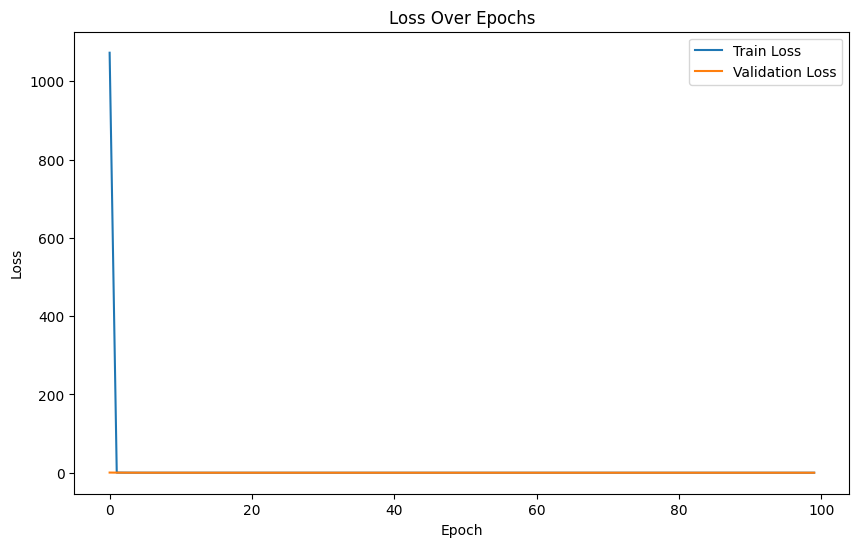

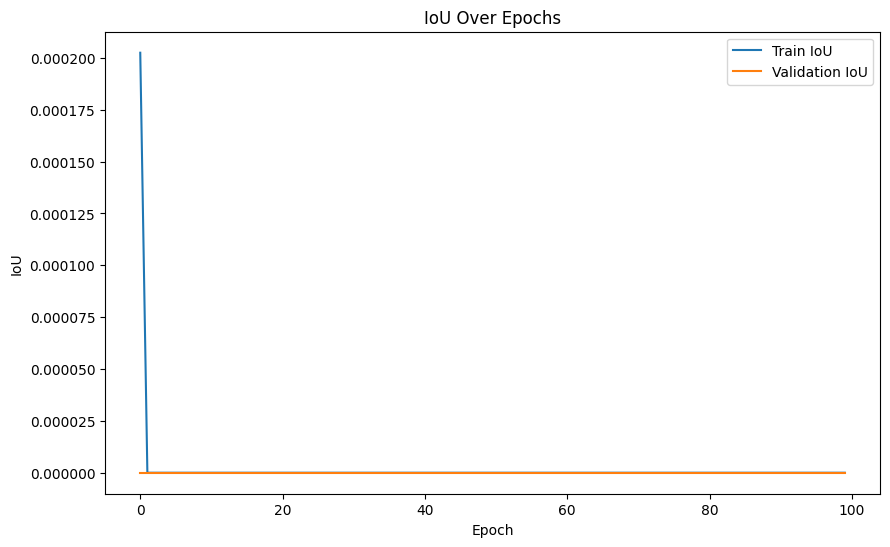

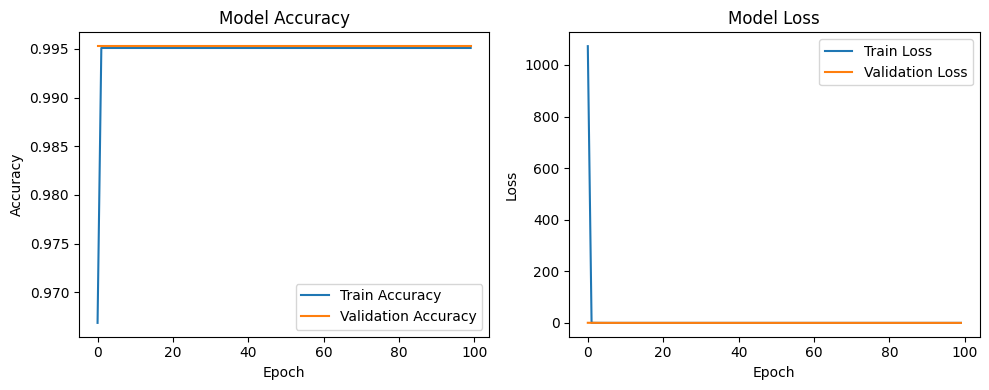

36/36 [==============================] - 6s 40ms/step
F1 점수: 0.99
=== 성능 지표 ===
정밀도(Precision): 0.99
재현율(Recall): 1.00


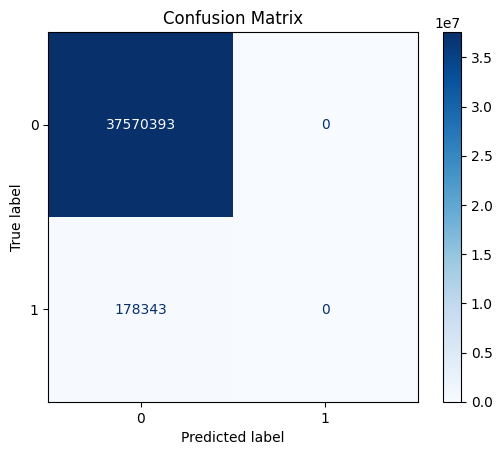

36/36 [==============================] - 2s 43ms/step


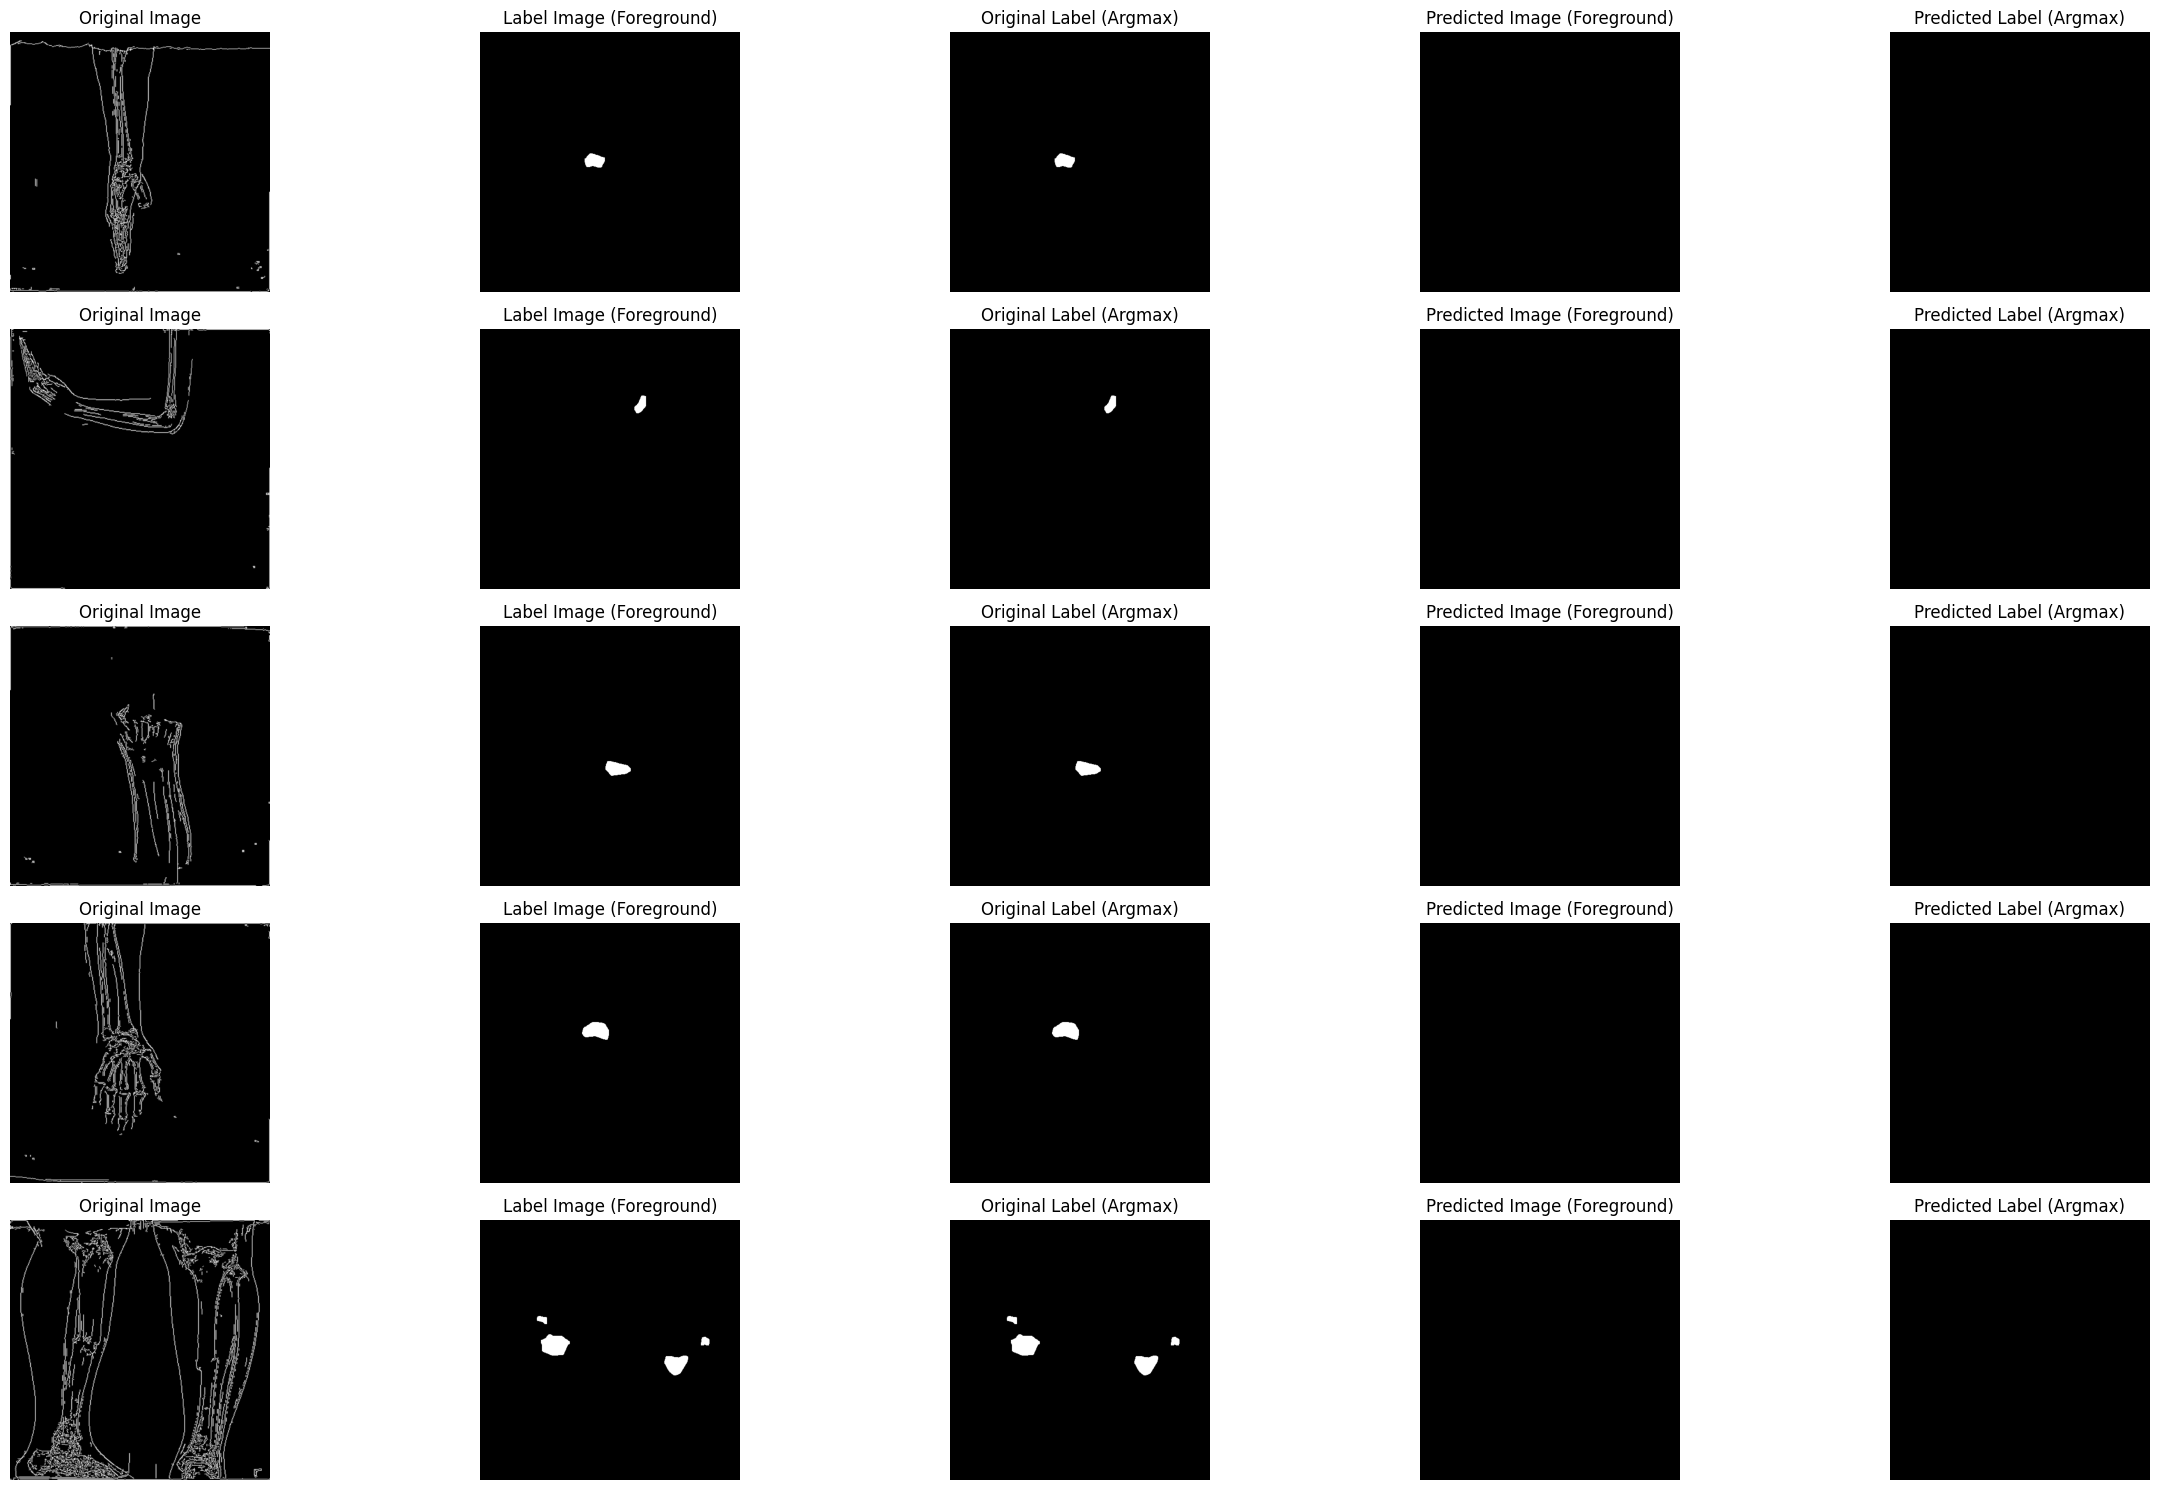

In [16]:
# 모델 학습

model, history = train_unet_with_weights(
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    batch_size=8,
    epochs=100
)
analyze_logs(history)
main_display_result(history, model, x_val, y_val, num_images=5, batch_size=4)

In [ ]:
# 모델 저장

model.save('unet_model.h5')  # .h5 파일 형식으로 모델 저장